In [1]:
cd ..

/home/tommy/Scrivania/Polimi/Honours Programme/SCFR


In [2]:
from os import listdir, path
import json
import matplotlib.pyplot as plt

from data_structures.cfr_trees import CFRTree
from games.goofspiel import build_goofspiel_tree
from games.kuhn import build_kuhn_tree
from games.leduc import build_leduc_tree
from functools import reduce

In [3]:
def parameters_to_string(par):
    if(par['game'] == 'kuhn'):
        return 'kuhn_' + str(par['players']) + '_' + str(par['rank'])
    if(par['game'] == 'leduc'):
        return 'leduc_' + str(par['players']) + '_' + str(par['suits']) + '_' + str(par['rank'])
    if(par['game'] == 'goofspiel'):
        return 'goofspiel_' + str(par['players']) + '_' + str(par['rank']) + '_' + str(par['tie_solver'])
    if(par['game'] == 'random'):
        return 'random_' + str(par['players']) + '_' + str(par['depth']) + '_' + str(par['branching_factor'])
    if(par['game'] == 'hanabi'):
        return 'hanabi_' + str(par['players']) + '_' + str(par['suits']) + '_' + \
                str(par['color_distribution']).replace(' ','').replace(',','_') + '_' + \
                str(par['cards_per_player']) + '_' + str(par['starting_clue_tokens'])

In [4]:
# TODO: check it, in particular for bigger versions of goofspiel
# TODO: implement different goofspiel TieSolver

def delta_utility(game, players, rank, betting_parameters = [2, 4], color_distribution = None, suits = 1):
    if game == 'kuhn':
        return 2 * players
    if game == 'leduc':
        return players + players * betting_parameters[0] + players * betting_parameters[1]
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return 1
    if game == 'hanabi':
        return (len(color_distribution) + 1) * suits

In [5]:
def max_social_welfare(game, players, rank, betting_parameters = [2, 4], color_distribution = None, suits = 1,
                      filename = None):
    if game == 'kuhn' or game == 'leduc':
        return 0
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return players
    if game == 'hanabi':
        u = (len(color_distribution)) * suits
        if filename.split('/')[-1] < '15567':
            u *= players
        return u

In [6]:
def compare(files, xlims_time = None, xlims_iter = None, ylims_epsilon = None, ylims_sw = None,
            legend = None, title = 'Comparison', show_sw = False, show_joint_size = False,
            not_sum_durations = None):
    fig_time, ax_time = plt.subplots()
    fig_iter, ax_iter = plt.subplots()
    if show_sw:
        fig_sw, ax_sw = plt.subplots()
    if show_joint_size:
        fig_sup, ax_sup = plt.subplots()
    
    for (i, filename) in enumerate(files):
        file = open(filename, "r")
        print(filename)
        data = json.load(file)
        file.close()

        #print("File = " + filename)
        #print("Game = " + parameters_to_string(data['parameters']))

        #print("Total iterations = " + str(data['parameters']['number_iterations']))
        #print("Check every iteration = " + str(data['parameters']['check_every_iteration']))
        
        if 'color_distribution' not in data['parameters']:
            data['parameters']['color_distribution'] = None

        durations = list(map(lambda el: el['duration'], data['data']))

        du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'], data['parameters']['color_distribution'], 
                   data['parameters']['suits'])

        iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
        epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
        percent_epsilons = list(map(lambda el: el / du, epsilons))
        if (not_sum_durations == None or not_sum_durations[i] == False):
            cum_durations = [sum(durations[:i]) for i in range(len(durations))]
        else:
            cum_durations = durations
        if show_sw:
            max_sw = max_social_welfare(data['parameters']['game'], data['parameters']['players'], 
                                        data['parameters']['rank'], data['parameters']['betting_parameters'], 
                                        data['parameters']['color_distribution'], data['parameters']['suits'],
                                        filename)
            social_welfares = list(map(lambda el: sum(el['utility']) / max_sw, data['data']))
        if show_joint_size:
            joint_size = list(map(lambda el: el['joint_support_size'], data['data']))
        
        ax_time.plot(cum_durations, percent_epsilons)
        ax_iter.plot(iteration_counts, percent_epsilons)
        if show_sw:
            ax_sw.plot(iteration_counts, social_welfares)
        if show_joint_size:
            ax_sup.plot(iteration_counts, joint_size)
        
    if legend == None:
        legend = ["Result " + str(i+1) for i in range(len(files))]
    ax_time.legend(legend, bbox_to_anchor = (1.05, 1), loc = 2)
    ax_iter.legend(legend, bbox_to_anchor = (1.05, 1), loc = 2)
    if show_sw:
        ax_sw.legend(legend, bbox_to_anchor = (1.05, 1), loc = 2)
    if show_joint_size:
        ax_sup.legend(legend, bbox_to_anchor = (1.05, 1), loc = 2)
    ax_time.set(xlabel = "Time [s]", ylabel = "Epsilon [%]")
    ax_iter.set(xlabel = "Iterations", ylabel = "Epsilon [%]")
    if show_sw:
        ax_sw.set(xlabel = "Iterations", ylabel = "Social welfare [%]")
    if show_joint_size:
        ax_sup.set(xlabel = "Iterations", ylabel = "Joint support size")
    if ylims_epsilon != None:
        ax_time.set_ylim(ylims_epsilon)
        ax_iter.set_ylim(ylims_epsilon)
    if show_sw and ylims_sw != None:
        ax_sw.set_ylim(ylims_sw)
    if xlims_time != None:
        ax_time.set_xlim(xlims_time)
    if xlims_iter != None:
        ax_iter.set_xlim(xlims_iter)
    ax_time.set_title(title)
    ax_iter.set_title(title)
    if show_sw:
        ax_sw.set_title(title)
    if show_joint_size:
        ax_sup.set_title(title)

---

# RCFR_nopt VS SCFR vs CFR

## Hanabi 2 players

results/remote/hanabi_tests/RCFR_nopt/hanabi/1554831012_2_2_[2_1]_1_1
results/remote/hanabi_tests/SCFR/hanabi/1554831004_2_2_[2_1]_1_1
results/remote/hanabi_tests/CFR/hanabi/1554909833_2_2_[2_1]_1_1


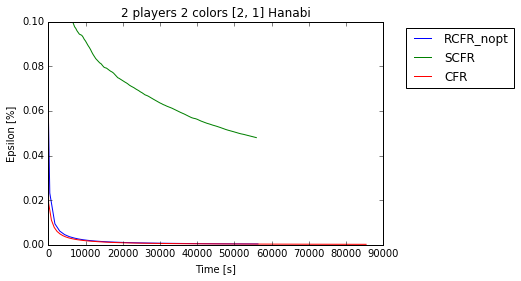

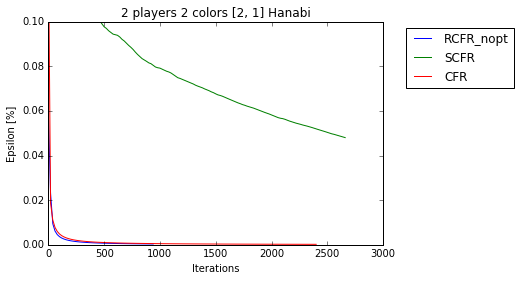

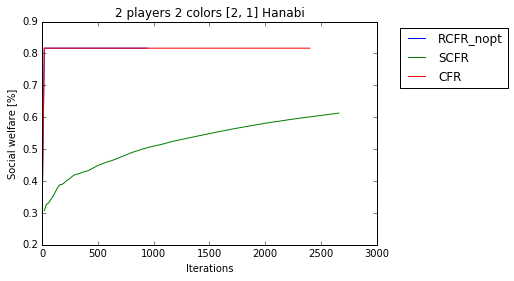

In [21]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1554831012_2_2_[2_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1554831004_2_2_[2_1]_1_1',
         'results/remote/hanabi_tests/CFR/hanabi/1554909833_2_2_[2_1]_1_1'],
        legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (0, 0.1), 
        title = '2 players 2 colors [2, 1] Hanabi', show_sw = True)

results/remote/hanabi_tests/RCFR_nopt/hanabi/1556811496_2_2_[2_1]_1_1_Uniform
results/remote/hanabi_tests/SCFR/hanabi/1556811508_2_2_[2_1]_1_1_Uniform
results/remote/hanabi_tests/CFR/hanabi/1556811527_2_2_[2_1]_1_1_Uniform


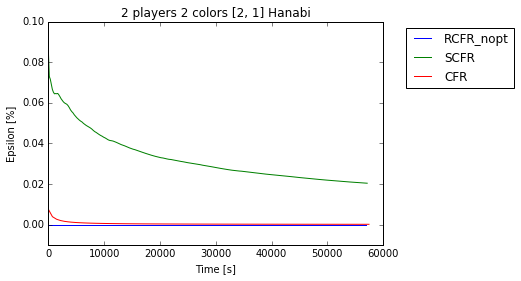

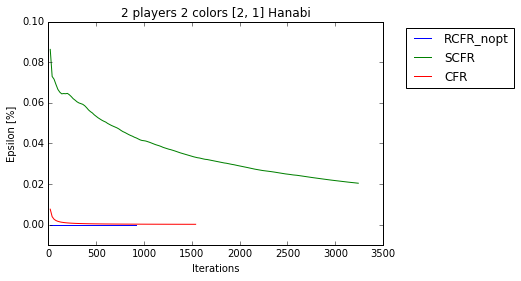

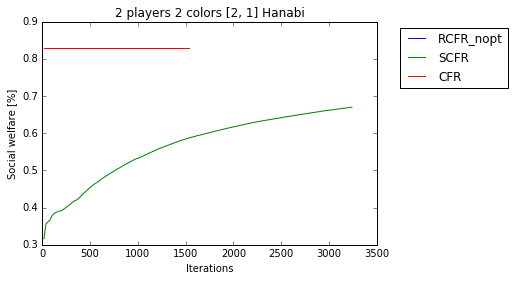

In [22]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1556811496_2_2_[2_1]_1_1_Uniform',
         'results/remote/hanabi_tests/SCFR/hanabi/1556811508_2_2_[2_1]_1_1_Uniform',
         'results/remote/hanabi_tests/CFR/hanabi/1556811527_2_2_[2_1]_1_1_Uniform'],
        legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (-0.01, 0.1), 
        title = '2 players 2 colors [2, 1] Hanabi', show_sw = True)

results/remote/hanabi_tests/RCFR_nopt/hanabi/1555356930_2_2_[1_1_1]_1_1
results/remote/hanabi_tests/SCFR/hanabi/1555356872_2_2_[1_1_1]_1_1
results/remote/hanabi_tests/CFR/hanabi/1555359570_2_2_[1_1_1]_1_1


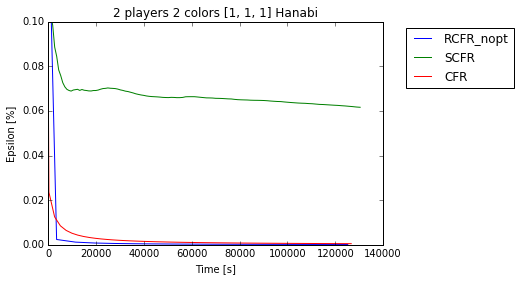

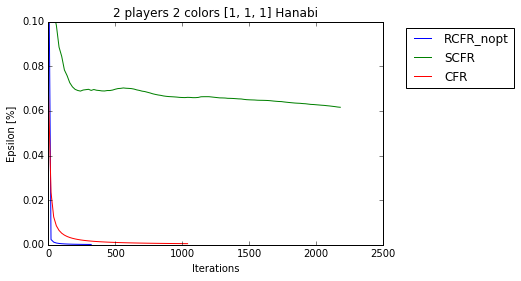

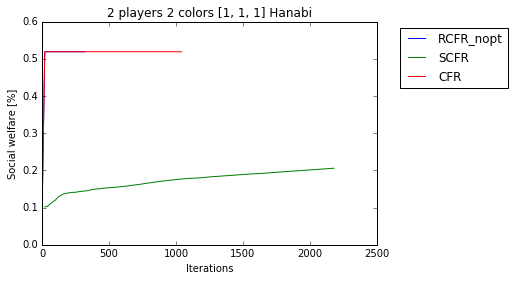

In [17]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1555356930_2_2_[1_1_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1555356872_2_2_[1_1_1]_1_1',
         'results/remote/hanabi_tests/CFR/hanabi/1555359570_2_2_[1_1_1]_1_1'],
        legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (0, 0.1), 
        title = '2 players 2 colors [1, 1, 1] Hanabi', show_sw = True)

## Hanabi 3 players

results/remote/hanabi_tests/RCFR_nopt/hanabi/1554739324_3_1_[2_2_1]_1_1
results/remote/hanabi_tests/SCFR/hanabi/1554739324_3_1_[2_2_1]_1_1
results/remote/hanabi_tests/CFR/hanabi/1554890546_3_1_[2_2_1]_1_1


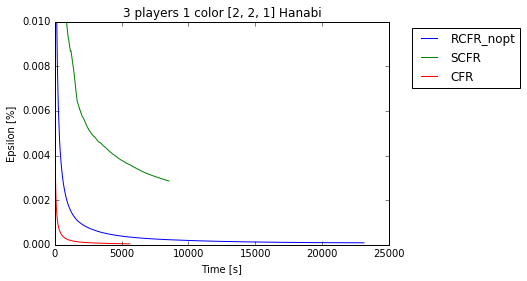

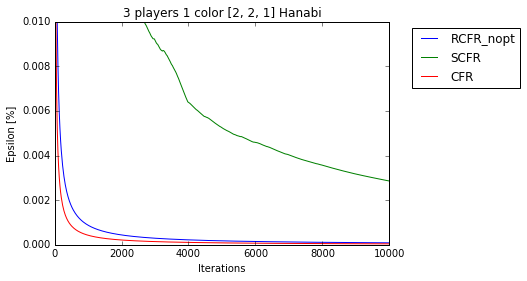

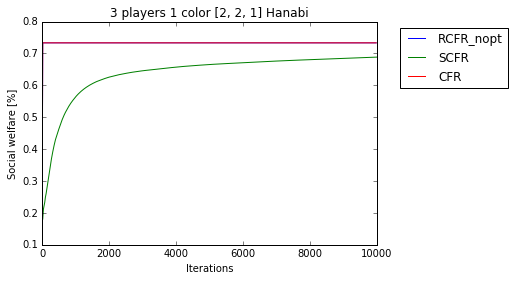

In [18]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1554739324_3_1_[2_2_1]_1_1',
         'results/remote/hanabi_tests/SCFR/hanabi/1554739324_3_1_[2_2_1]_1_1',
         'results/remote/hanabi_tests/CFR/hanabi/1554890546_3_1_[2_2_1]_1_1'],
        legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (0, 0.01),
        title = '3 players 1 color [2, 2, 1] Hanabi', show_sw = True)

results/remote/hanabi_tests/SCFR/hanabi/1555148528_3_2_[2_1]_1_1
results/remote/hanabi_tests/CFR/hanabi/1555148597_3_2_[2_1]_1_1


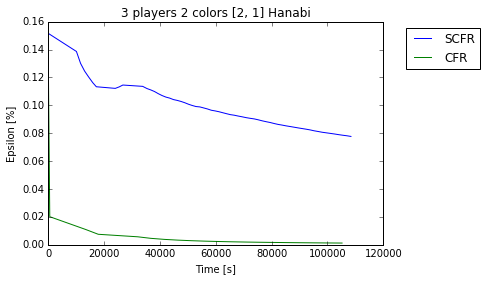

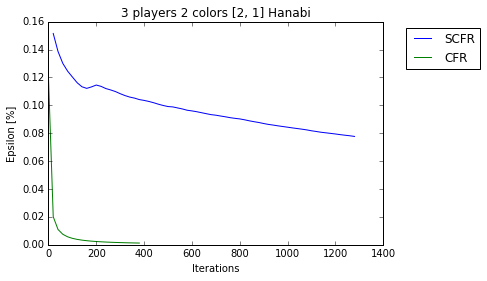

In [19]:
compare(['results/remote/hanabi_tests/SCFR/hanabi/1555148528_3_2_[2_1]_1_1',
         'results/remote/hanabi_tests/CFR/hanabi/1555148597_3_2_[2_1]_1_1'],
         legend = ['SCFR', 'CFR'],
         title = '3 players 2 colors [2, 1] Hanabi')

results/remote/hanabi_tests/RCFR_nopt/hanabi/1556460580_3_1_[2_2_2]_1_1_Uniform
results/remote/hanabi_tests/RCFR_nopt/hanabi/1556550389_3_1_[2_2_2]_1_1_Uniform
results/remote/hanabi_tests/SCFR/hanabi/1556460558_3_1_[2_2_2]_1_1_Uniform
results/remote/hanabi_tests/CFR/hanabi/1556460553_3_1_[2_2_2]_1_1_Uniform


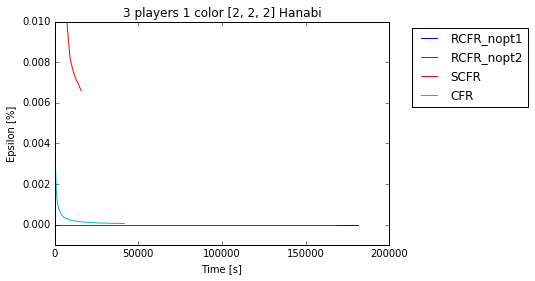

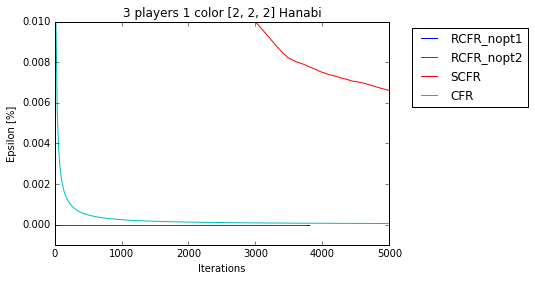

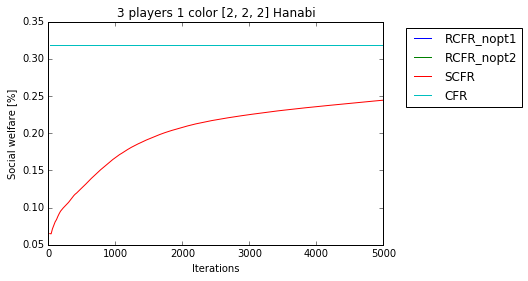

In [20]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1556460580_3_1_[2_2_2]_1_1_Uniform',
         'results/remote/hanabi_tests/RCFR_nopt/hanabi/1556550389_3_1_[2_2_2]_1_1_Uniform',
         'results/remote/hanabi_tests/SCFR/hanabi/1556460558_3_1_[2_2_2]_1_1_Uniform',
         'results/remote/hanabi_tests/CFR/hanabi/1556460553_3_1_[2_2_2]_1_1_Uniform'],
        legend = ['RCFR_nopt1', 'RCFR_nopt2', 'SCFR', 'CFR'], ylims_epsilon = (-0.001, 0.01),
        title = '3 players 1 color [2, 2, 2] Hanabi', show_sw = True)

## Different reconstruction rates

results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate100
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate50
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate20
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate10
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate5
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate2
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate1


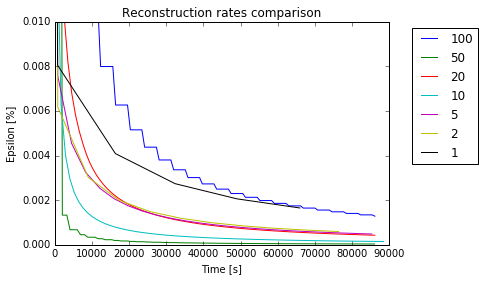

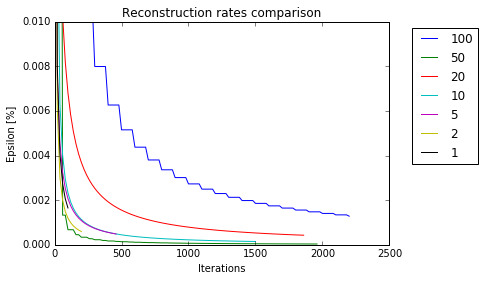

In [21]:
compare(['results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate100',
         'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate50',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate20',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate10',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate5',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate2',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate1'],
        legend = ['100', '50', '20', '10', '5', '2', '1'], ylims_epsilon = (0, 0.01),
        title = 'Reconstruction rates comparison')

results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate5
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate2
results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate1


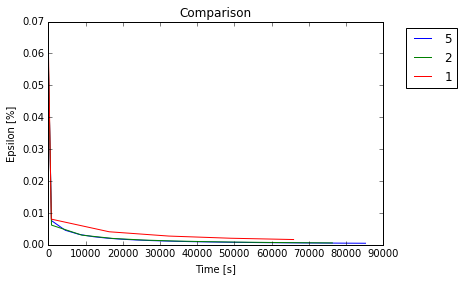

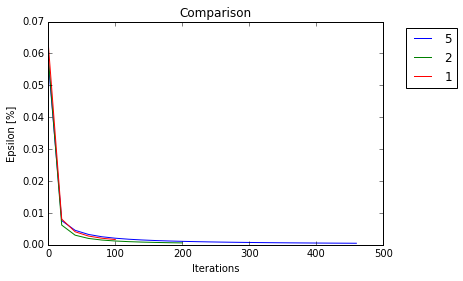

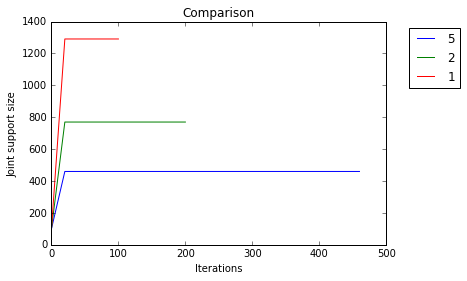

In [22]:
compare(['results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate5',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate2',
        'results/remote/hanabi_tests/rate_comparison/2_2_[2_1]_1_1_rate1'],
        show_joint_size = True, legend = ['5', '2', '1'])

## Competitive Hanabi

results/remote/hanabi_tests/RCFR_nopt/hanabi/1555500678_2_2_[2_1]_1_1_Competitive
results/remote/hanabi_tests/SCFR/hanabi/1555500681_2_2_[2_1]_1_1_Competitive
results/remote/hanabi_tests/CFR/hanabi/1555500678_2_2_[2_1]_1_1_Competitive


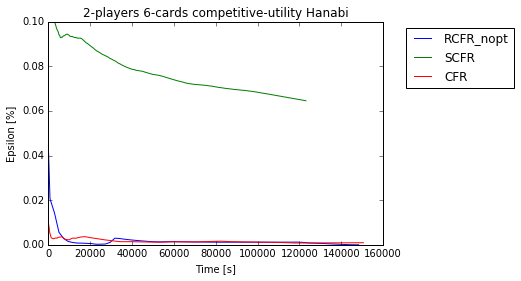

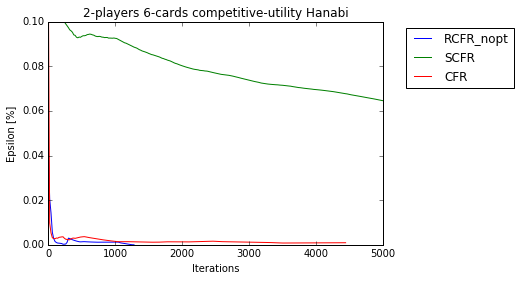

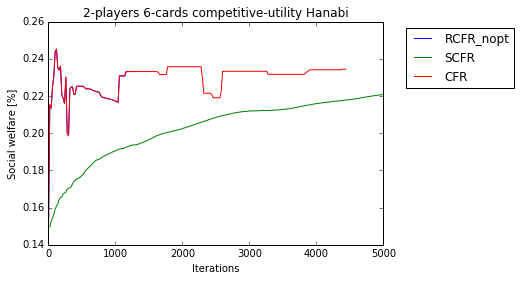

In [11]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1555500678_2_2_[2_1]_1_1_Competitive',
        'results/remote/hanabi_tests/SCFR/hanabi/1555500681_2_2_[2_1]_1_1_Competitive',
        'results/remote/hanabi_tests/CFR/hanabi/1555500678_2_2_[2_1]_1_1_Competitive'],
        show_sw = True, legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (0, 0.1),
        title = '2-players 6-cards competitive-utility Hanabi')

results/remote/hanabi_tests/RCFR_nopt/hanabi/1556878003_2_2_[2_1]_1_1_Competitive
results/remote/hanabi_tests/SCFR/hanabi/1556878033_2_2_[2_1]_1_1_Competitive
results/remote/hanabi_tests/CFR/hanabi/1556878015_2_2_[2_1]_1_1_Competitive


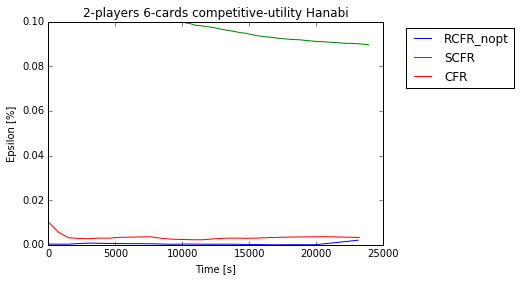

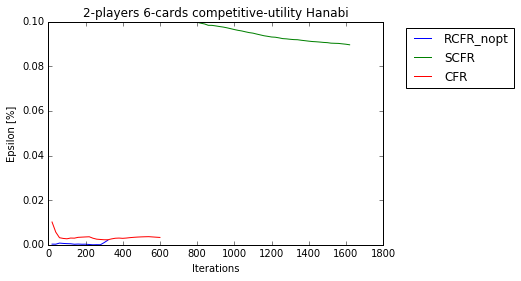

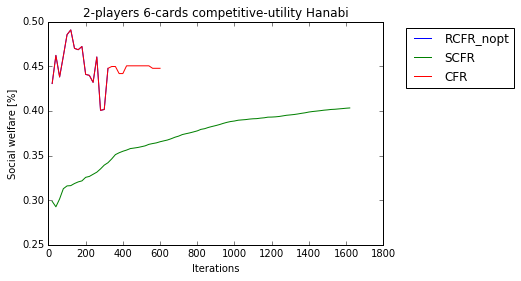

In [7]:
compare(['results/remote/hanabi_tests/RCFR_nopt/hanabi/1556878003_2_2_[2_1]_1_1_Competitive',
        'results/remote/hanabi_tests/SCFR/hanabi/1556878033_2_2_[2_1]_1_1_Competitive',
        'results/remote/hanabi_tests/CFR/hanabi/1556878015_2_2_[2_1]_1_1_Competitive'],
        show_sw = True, legend = ['RCFR_nopt', 'SCFR', 'CFR'], ylims_epsilon = (0, 0.1),
        title = '2-players 6-cards competitive-utility Hanabi')

# Goofspiel

### New

results/remote/goofspiel_RCFR_nopt/goofspiel/1555879067_3_4_accumulate
results/remote/goofspiel_RCFR_nopt/goofspiel/1556056269_3_4_accumulate
results/remote/goofspiel_RCFR_nopt/goofspiel/1556284653_3_4_accumulate
results/remote/goofspiel_RCFR_nopt/goofspiel/1556926187_3_4_Accumulate
results/remote/goofspiel_CFR_new/goofspiel/1555835041_3_4_accumulate
results/remote/goofspiel_CFR_new/goofspiel/1556175816_3_4_accumulate
results/remote/goofspiel_CFR_new/goofspiel/1556175823_3_4_accumulate


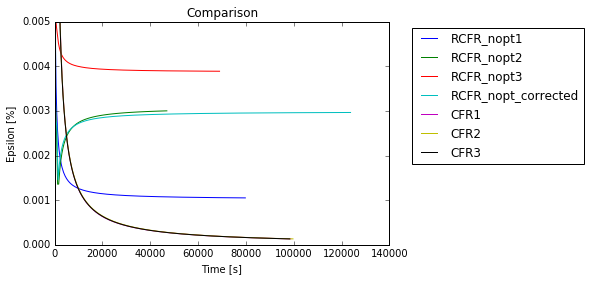

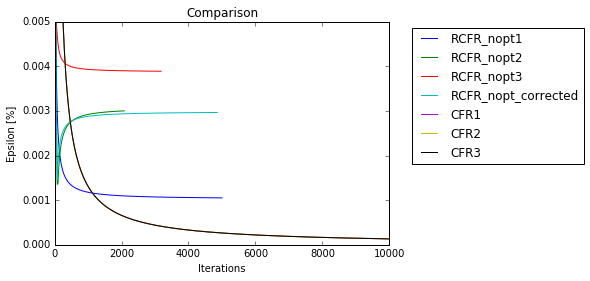

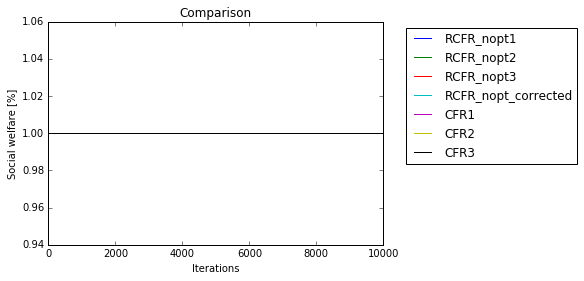

In [27]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555879067_3_4_accumulate',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556056269_3_4_accumulate',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556284653_3_4_accumulate',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556926187_3_4_Accumulate',
         'results/remote/goofspiel_CFR_new/goofspiel/1555835041_3_4_accumulate',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175816_3_4_accumulate',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175823_3_4_accumulate'],
         ylims_epsilon = (0, 0.005), 
         legend = ['RCFR_nopt1', 'RCFR_nopt2', 'RCFR_nopt3', 'RCFR_nopt_corrected', 'CFR1', 'CFR2', 'CFR3'],
         show_sw = True)

results/remote/goofspiel_RCFR_nopt/goofspiel/1555856019_3_4_discard_if_high
results/remote/goofspiel_CFR_new/goofspiel/1555835057_3_4_discard_if_high
results/remote/goofspiel_RCFR_nopt/goofspiel/1556056286_3_4_discard_if_high
results/remote/goofspiel_RCFR_nopt/goofspiel/1556926174_3_4_DiscardIfHigh
results/remote/goofspiel_RCFR_nopt/goofspiel/1556284621_3_4_discard_if_high
results/remote/goofspiel_CFR_new/goofspiel/1556175799_3_4_discard_if_high
results/remote/goofspiel_CFR_new/goofspiel/1556175807_3_4_discard_if_high


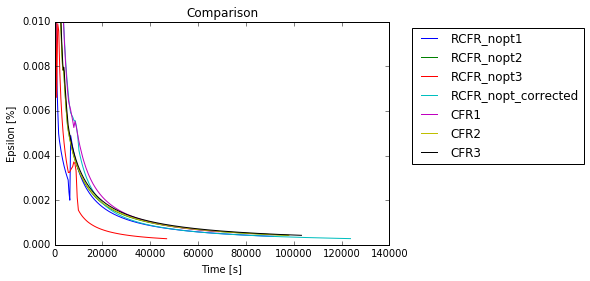

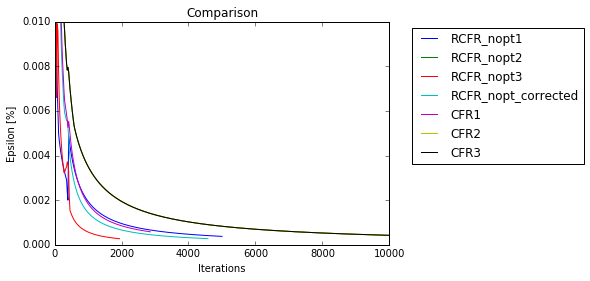

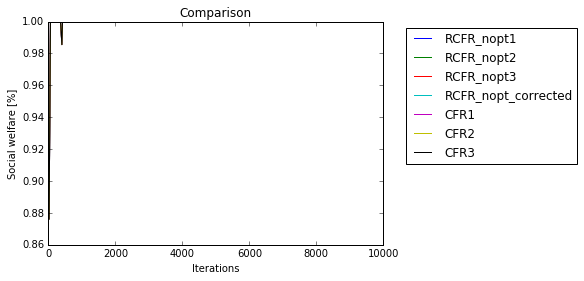

In [10]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555856019_3_4_discard_if_high',
         'results/remote/goofspiel_CFR_new/goofspiel/1555835057_3_4_discard_if_high',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556056286_3_4_discard_if_high',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556926174_3_4_DiscardIfHigh',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556284621_3_4_discard_if_high',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175799_3_4_discard_if_high',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175807_3_4_discard_if_high'],
         ylims_epsilon = (0, 0.01),
         legend = ['RCFR_nopt1', 'RCFR_nopt2', 'RCFR_nopt3', 'RCFR_nopt_corrected', 'CFR1', 'CFR2', 'CFR3'],
         show_sw = True)

results/remote/goofspiel_RCFR_nopt/goofspiel/1555856026_3_4_discard_if_all
results/remote/goofspiel_RCFR_nopt/goofspiel/1556056279_3_4_discard_if_all
results/remote/goofspiel_RCFR_nopt/goofspiel/1556284616_3_4_discard_if_all
results/remote/goofspiel_RCFR_nopt/goofspiel/1556802205_3_4_DiscardIfAll
results/remote/goofspiel_CFR_new/goofspiel/1555835047_3_4_discard_if_all
results/remote/goofspiel_CFR_new/goofspiel/1556175786_3_4_discard_if_all
results/remote/goofspiel_CFR_new/goofspiel/1556175791_3_4_discard_if_all


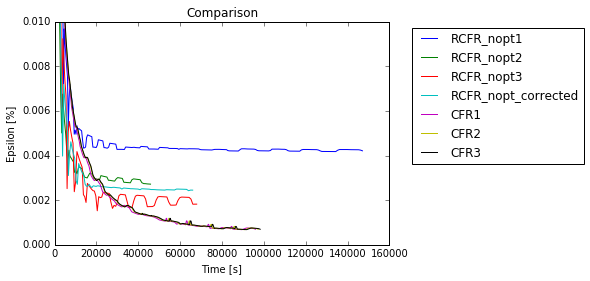

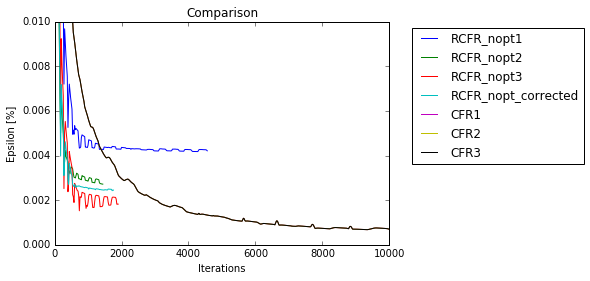

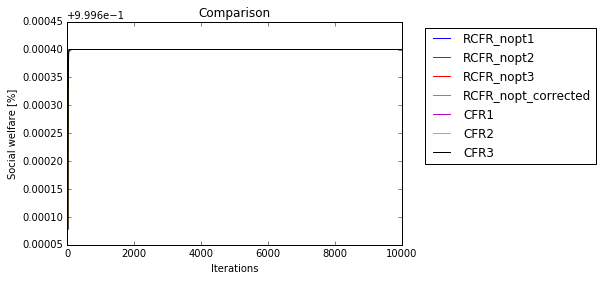

In [11]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555856026_3_4_discard_if_all',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556056279_3_4_discard_if_all',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556284616_3_4_discard_if_all',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556802205_3_4_DiscardIfAll',
         'results/remote/goofspiel_CFR_new/goofspiel/1555835047_3_4_discard_if_all',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175786_3_4_discard_if_all',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175791_3_4_discard_if_all'],
         ylims_epsilon = (0, 0.01), 
         legend = ['RCFR_nopt1', 'RCFR_nopt2', 'RCFR_nopt3', 'RCFR_nopt_corrected', 'CFR1', 'CFR2', 'CFR3'], 
         show_sw = True)

results/remote/goofspiel_RCFR_nopt/goofspiel/1555879046_3_4_dicard_always
results/remote/goofspiel_RCFR_nopt/goofspiel/1556056288_3_4_discard_always
results/remote/goofspiel_RCFR_nopt/goofspiel/1556284629_3_4_discard_always
results/remote/goofspiel_RCFR_nopt/goofspiel/1556926175_3_4_DiscardAlways
results/remote/goofspiel_CFR_new/goofspiel/1555835055_3_4_discard_always
results/remote/goofspiel_CFR_new/goofspiel/1556175768_3_4_discard_always
results/remote/goofspiel_CFR_new/goofspiel/1556175773_3_4_discard_always


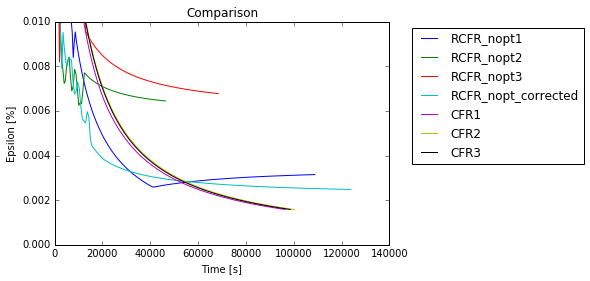

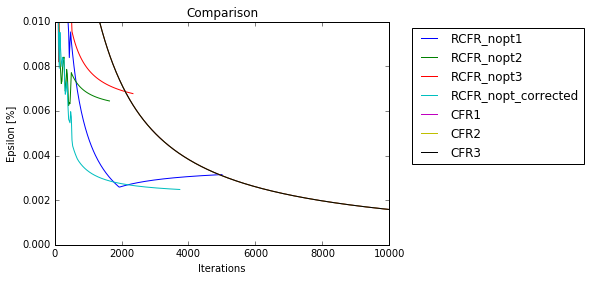

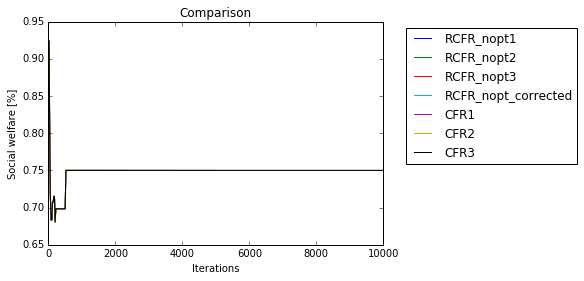

In [12]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555879046_3_4_dicard_always',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556056288_3_4_discard_always',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556284629_3_4_discard_always',
         'results/remote/goofspiel_RCFR_nopt/goofspiel/1556926175_3_4_DiscardAlways',
         'results/remote/goofspiel_CFR_new/goofspiel/1555835055_3_4_discard_always',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175768_3_4_discard_always',
         'results/remote/goofspiel_CFR_new/goofspiel/1556175773_3_4_discard_always'],
         ylims_epsilon = (0, 0.01), 
         legend = ['RCFR_nopt1', 'RCFR_nopt2', 'RCFR_nopt3', 'RCFR_nopt_corrected', 'CFR1', 'CFR2', 'CFR3'],
         show_sw = True)

### Old (probably wrong)

results/remote/RCFR_notopt/goofspiel/1554382206_3_4
results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate


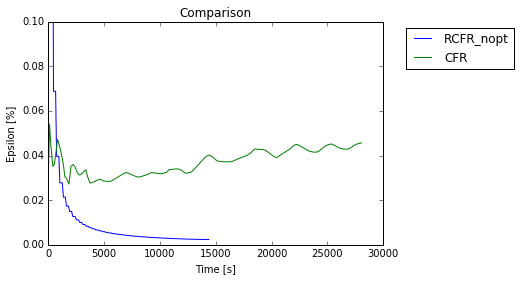

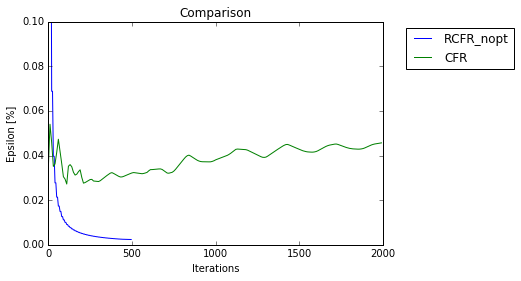

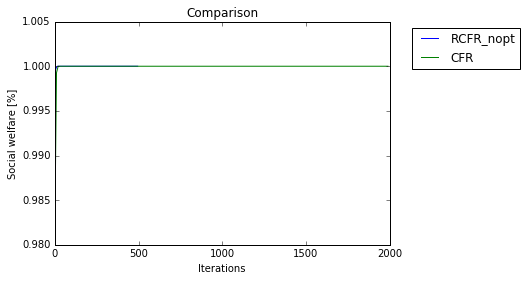

In [28]:
compare(['results/remote/RCFR_notopt/goofspiel/1554382206_3_4',
         'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate'],
         ylims_epsilon = (0, 0.1), legend = ['RCFR_nopt', 'CFR'], show_sw = True, 
         not_sum_durations = [False, True])

results/remote/goofspiel_RCFR_nopt/goofspiel/1555617948_3_4_accumulate
results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate


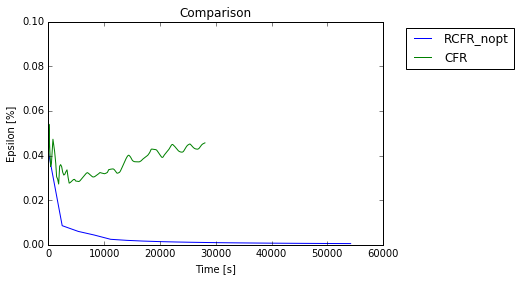

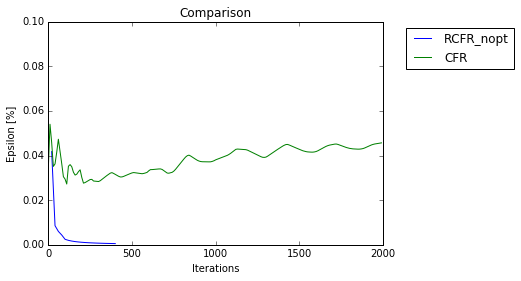

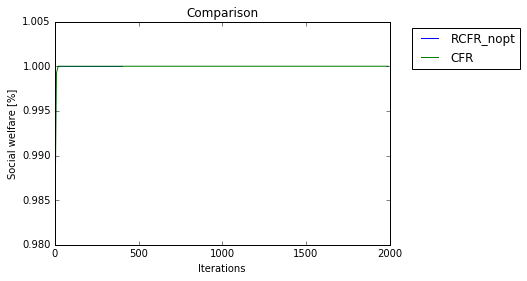

In [29]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555617948_3_4_accumulate',
         'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate'],
         ylims_epsilon = (0, 0.1), legend = ['RCFR_nopt', 'CFR'], show_sw = True, 
         not_sum_durations = [False, True])

results/remote/goofspiel_RCFR_nopt/goofspiel/1555617945_3_4_discard_always
results/remote/goofspiel_cfr_20190121/1548066663_3_4


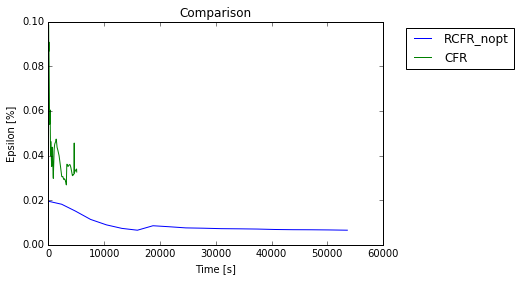

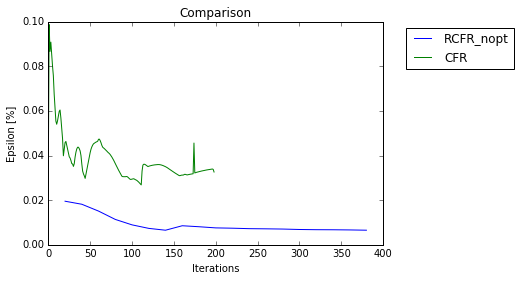

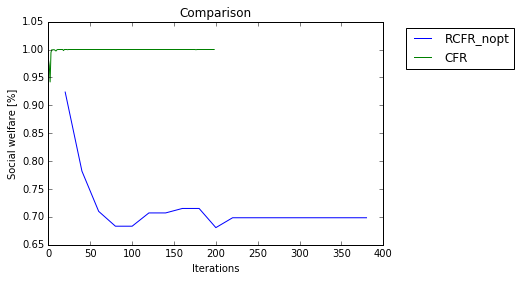

In [30]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555617945_3_4_discard_always',
         'results/remote/goofspiel_cfr_20190121/1548066663_3_4'],
         ylims_epsilon = (0, 0.1), legend = ['RCFR_nopt', 'CFR'], show_sw = True, 
         not_sum_durations = [False, True])

results/remote/goofspiel_RCFR_nopt/goofspiel/1555617947_3_4_discard_if_high
results/remote/goofspiel_cfr_20190121/1548066666_3_4


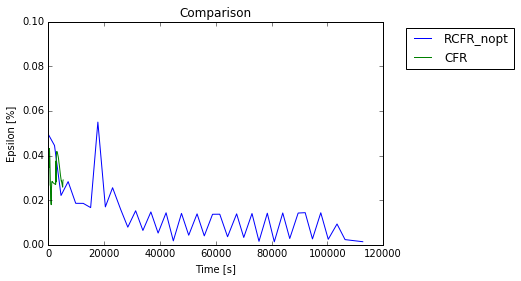

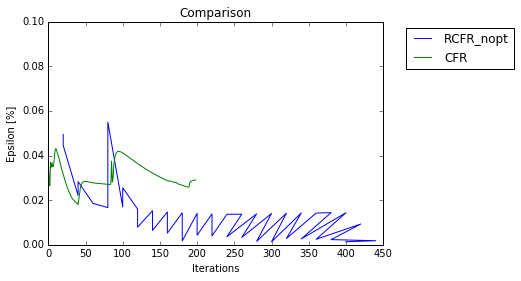

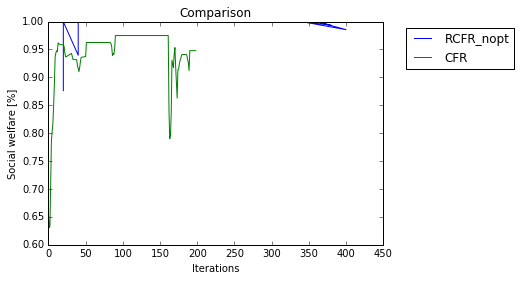

In [31]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555617947_3_4_discard_if_high',
         'results/remote/goofspiel_cfr_20190121/1548066666_3_4'],
         ylims_epsilon = (0, 0.1), legend = ['RCFR_nopt', 'CFR'], show_sw = True, 
         not_sum_durations = [False, True])

results/remote/goofspiel_RCFR_nopt/goofspiel/1555491686_3_4_discard_if_all
results/remote/goofspiel_cfr_20190121/1548066664_3_4


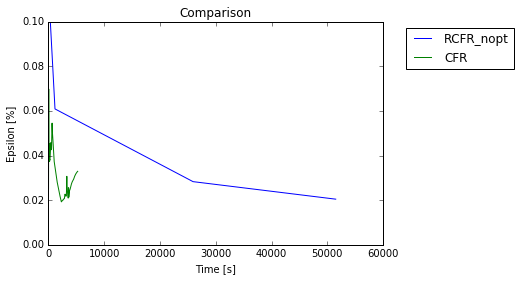

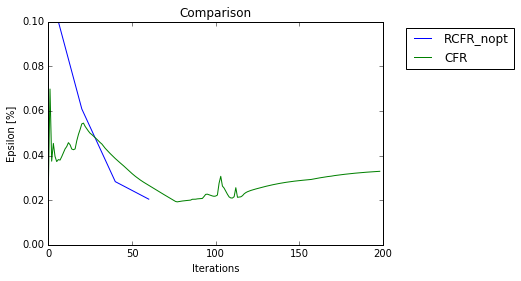

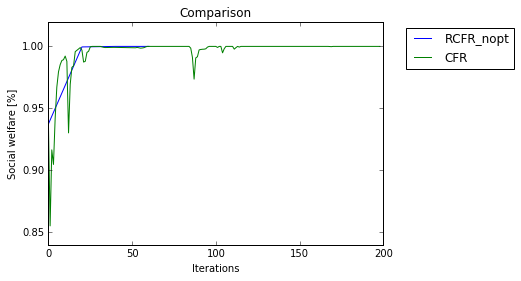

In [32]:
compare(['results/remote/goofspiel_RCFR_nopt/goofspiel/1555491686_3_4_discard_if_all',
         'results/remote/goofspiel_cfr_20190121/1548066664_3_4'],
         ylims_epsilon = (0, 0.1), legend = ['RCFR_nopt', 'CFR'], show_sw = True, 
         not_sum_durations = [False, True])